## $\textbf{Input}$

In [ ]:
stock_symbl = 'MSFT'
data_file = 'data_msft.csv'

## $\textbf{Imports}$

In [ ]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from datetime import date, timedelta
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
 
from sklearn.metrics import mean_squared_error
plt.style.use('ggplot')
 
!pip install alpha_vantage
import requests

     |████████████████████████████████| 1.3MB 12.8MB/s 
     |████████████████████████████████| 143kB 37.0MB/s 
     |████████████████████████████████| 296kB 36.3MB/s 


## $\textbf{Downloading fundamental Data into dataframe}$

In [ ]:

API_URL = "https://www.alphavantage.co/query" 


data_earnings = { 
    "function": 'EARNINGS', 
    "symbol": stock_symbl,
    "outputsize" : "compact",
    "datatype": "json", 
    "apikey": '0J60AGKUN42KGVXB'} 

response_earnings = requests.get(API_URL, data_earnings) 
response_earnings_json = response_earnings.json()

earnings_df = pd.DataFrame(response_earnings_json['quarterlyEarnings'])
earnings_df.set_index('fiscalDateEnding',inplace=True)


eps = earnings_df[['reportedEPS']]
eps


data_inc = { 
    "function": 'INCOME_STATEMENT', 
    "symbol": stock_symbl,
    "outputsize" : "full",
    "datatype": "pandas", 
    "apikey": '0J60AGKUN42KGVXB'} 

response_inc = requests.get(API_URL, data_inc) 
response_inc_json = response_inc.json()


inc_dic = {
            'fiscalDateEnding' : [],
            'operatingIncome' : [],
            'grossProfit': [],
            'totalRevenue' :[]
          }

for i in range(len(response_inc_json['quarterlyReports'])):
  inc_dic['fiscalDateEnding'].append(response_inc_json['quarterlyReports'][i]['fiscalDateEnding'])
  inc_dic['operatingIncome'].append(10e-6*float(response_inc_json['quarterlyReports'][i]['operatingIncome']))
  inc_dic['grossProfit'].append(10e-6*float(response_inc_json['quarterlyReports'][i]['grossProfit']))
  inc_dic['totalRevenue'].append(10e-6*float(response_inc_json['quarterlyReports'][i]['totalRevenue']))

income_stmt = pd.DataFrame(inc_dic)
income_stmt.set_index('fiscalDateEnding', inplace=True)

new_inc = pd.read_csv(data_file)
new_inc.dropna(axis=1, inplace=True)

new_inc.columns = ['fiscalDateEnding', 'totalRevenue', 'grossProfit', 'operatingIncome']
new_inc.set_index('fiscalDateEnding',inplace=True)


income_stmt = income_stmt.append(new_inc)
#income_stmt


In [ ]:
income_stmt

,operatingIncome,grossProfit,totalRevenue
fiscalDateEnding,,,
2021-03-31,170480.0,286610.0,410590.0
2020-12-31,178970.0,288820.0,425580.0
2020-09-30,158760.0,261520.0,367240.0
2020-06-30,134070.0,256940.0,374380.0
2020-03-31,129750.0,240460.0,343150.0
2019-12-31,138910.0,245480.0,363220.0
2019-09-30,126860.0,226490.0,324280.0
2019-06-30,124050.0,233050.0,330910.0
2019-03-31,103410.0,204010.0,305710.0


## $\textbf{Defining fucntions}$

In [ ]:
def calculate_rsi(close_price_df, period=14):
  '''
  This function calculated the Relative Strength Index (RSI) from the prices. The defualt period to calculate RSI
  has been set to 14. 
  
  Parameters:

  close_price_df: It should be a dataframe with only one column that contains the close prices of the stock. This dataframe
                  must contain the date as index. Because this function when used inside other functions, helps in joining dataframe
                  on date index (datetime object). Hence if the index is not date then it would create problems while joining thid with other datafrae.
  period :(use int) This is the period using which RSI is calculated. If any other data type is used, it will be converted to int
  '''
  period = int(period)

  rsi_dummy = close_price_df.copy(True)
  rsi_dummy.dropna(axis=0, inplace=True)
  rsi_dummy['Change'] = rsi_dummy.iloc[:,[0]] - rsi_dummy.iloc[:,[0]].shift(1)
  rsi_dummy['Gain'] = np.where(rsi_dummy['Change']>0,rsi_dummy['Change'],0)
  rsi_dummy['Loss'] = np.where(rsi_dummy['Change']<0,-rsi_dummy['Change'],0)
  avg_gain = []
  avg_loss = []

  for i in range(len(rsi_dummy)):
    if (i<(period-1)):
      avg_gain.append(np.NaN)
      avg_loss.append(np.NaN)
    elif i==(period-1):
      avg_gain.append((rsi_dummy['Gain'][0:period].values.sum())/period)
      avg_loss.append((rsi_dummy['Loss'][0:period].values.sum())/period)
    else:
      avg_gain.append( (avg_gain[i-1]*(period-1) + rsi_dummy['Gain'][i] )/period   )
      avg_loss.append( (avg_loss[i-1]*(period-1) + rsi_dummy['Loss'][i] )/period   )

  rsi_dummy['Avg_gain'] = np.array(avg_gain)
  rsi_dummy['Avg_loss'] = np.array(avg_loss)
  rsi_dummy['RS'] = rsi_dummy['Avg_gain'] / rsi_dummy['Avg_loss']
  rsi_dummy['RSI'] = np.where(rsi_dummy['Avg_loss']==0,100, 100-(100/(1+rsi_dummy['RS'])) )
  rsi_dummy = rsi_dummy.dropna(axis=0)
  return rsi_dummy[['RSI']]



def calculate_MACD(data_df,fast_period=12 , slow_period=26, signal_period=9 ):
  '''
  This function calculates the the four colums, macd_fast, macd_sloe, macd, and macd_signal. For clearer understanding read how macd is calculated.
  The parameters are simply the periods of the fast, slow, and signal exponential averages.

  The default values for fast_period, slow_period and signal_period are 12, 26 and 9 respectively.

  The data_df should be a dataframe with index as date time object and it should only contain one column for the closing price of the stock, on which
  the macd moving averages will be calculated. If you want to calculate the same averages and signal on opening prices, or high, or low, then you can
  replace the closing price, column with that.
  '''

  fast_period = int(fast_period)
  slow_period = int(slow_period)
  signal_period = int(signal_period)

  macd = data_df.iloc[:,[0]].copy(True)
  macd = macd.dropna(axis=0)
  macd['macd_fast'] = macd.iloc[:,[0]].ewm(span=fast_period, min_periods=fast_period).mean()
  macd['macd_slow'] = macd.iloc[:,[0]].ewm(span=slow_period, min_periods=slow_period).mean()
  macd['MACD'] = macd['macd_fast'] - macd['macd_slow']
  macd['macd_signal'] = macd['MACD'].ewm(span=signal_period, min_periods=signal_period).mean()
  macd = macd.dropna(axis=0)
  
  return macd[['macd_fast', 'macd_slow', 'MACD', 'macd_signal']]



def calculate_ATR(data_df, atr_period=14):
  '''
  ATR calculated the Average True range. atr_period is the period according to which the moving average is calculated.
  The default is 14.

  data_df should be a dataframe with index as a datetime object so that you can easily join this later with your data.
  data_df should contain the following columns, 'High', 'Low', 'Adj Close', they can be in any order.
  '''

  atr_period = int(atr_period)

  atr_df = data_df.copy(True)
  atr_df = atr_df.dropna(axis=0)

  atr_df['H-L'] = abs(atr_df['High'] - atr_df['Low'])
  atr_df['H-Cp'] = abs(atr_df['High'] - atr_df['Adj Close'].shift(1))
  atr_df['L-Cp'] = abs(atr_df['Low'] - atr_df['Adj Close'].shift(1))
  atr_df['TR']  = atr_df[['H-L', 'H-Cp', 'L-Cp']].max(axis=1, skipna=False)
  atr_df['ATR'] = atr_df['TR'].rolling(atr_period).mean()
  atr_df = atr_df.dropna(axis=0)

  return atr_df[['ATR']]



def calculate_OBV(data_df):
  '''
  This function calculated the On-Balace Volume(OBV) from the given data.
  data_df must be a dataframe with these two columns, 'Adj Close' and 'Volume'

  '''
  obv_df = data_df.copy(True)
  obv_df = obv_df.dropna(axis=0)
  obv_df['rtn'] = obv_df['Adj Close'].pct_change()
  obv_df['Adj_volume'] = np.where(obv_df['rtn']>0, obv_df['Volume'], -obv_df['Volume'])
  obv_df['Adj_volume'][0] = 0
  obv_df['OBV'] = obv_df['Adj_volume'].cumsum()
  obv_df = obv_df.dropna(axis=0)

  return obv_df[['OBV']]



def calculate_Bollinger_Band(data_df, bb_sma_period=20):
  '''
  This function calculate the bollinger band for th given data.

  data_df must be a dataframe with only close price as the column 
    (Should contain only one column, The function takes the first column 
    as the close 
    prices). And the index of the data_df should be a datetime object for further convenienceto join the dataframe.

  bb_sma_period is the simple moving average period to calculate the bollinger band. 
  '''
  bb_sma_period = int(bb_sma_period)
  bb_df = data_df.copy(True)
  bb_df = bb_df.dropna(axis=0)

  bb_df['MA'] = bb_df.iloc[:,[0]].rolling(bb_sma_period).mean()
  bb_df['BB_upper'] = bb_df['MA'] + 2*bb_df['MA'].rolling(bb_sma_period).std()
  bb_df['BB_lower'] = bb_df['MA'] - 2*bb_df['MA'].rolling(bb_sma_period).std()
  bb_df = bb_df.dropna(axis=0)

  return bb_df[['BB_upper', 'BB_lower']]




def calculate_ADX(data_df, adx_period=14):
  '''
  This function calculated the Average Directional index (ADX). 

  data_df : Must be a dataframe with columns, 'High', 'Low', and 'Adj Close'. Index must be a datetime object (date)

  '''
  adx_period = int(adx_period) 
  adx_df = data_df.copy(True)
  adx_df = adx_df.dropna(axis=0)

  adx_df['H-L'] = abs(adx_df['High'] - adx_df['Low'])
  adx_df['H-Cp'] = abs(adx_df['High'] - adx_df['Adj Close'].shift(1))
  adx_df['L-Cp'] = abs(adx_df['Low'] - adx_df['Adj Close'].shift(1))
  adx_df['TR']  = adx_df[['H-L', 'H-Cp', 'L-Cp']].max(axis=1, skipna=False)
  adx_df['+DM_1'] = np.where((adx_df['High']-adx_df['High'].shift(1)) >( adx_df['Low'].shift(1) -adx_df['Low']), adx_df['High']-adx_df['High'].shift(1), 0 )
  adx_df['+DM_1'] = np.where(adx_df['+DM_1']<0, 0 ,adx_df['+DM_1'])
  adx_df['-DM_1'] = np.where((adx_df['Low'].shift(1)-adx_df['Low'])>(adx_df['High']-adx_df['High'].shift(1)),adx_df['Low'].shift(1)-adx_df['Low'],0)
  adx_df['-DM_1'] = np.where(adx_df['-DM_1'] <0, 0,adx_df['-DM_1'])
  adx_df['+DM_1'][0] = np.NaN
  adx_df['-DM_1'][0] = np.NaN

  TR_N = []
  DM_plus_N = []
  DM_minus_N = []

  for i in range(len(adx_df)):
    if i < (adx_period):
      TR_N.append(np.NaN)
      DM_plus_N.append(np.NaN)
      DM_minus_N.append(np.NaN)
    elif i == (adx_period):
      TR_N.append(adx_df['TR'][:adx_period+1].sum())
      DM_plus_N.append(adx_df['+DM_1'][:adx_period+1].sum())
      DM_minus_N.append(adx_df['-DM_1'][:adx_period+1].sum())
    else:
      TR_N.append(TR_N[i-1]*((adx_period-1)/adx_period) + adx_df['TR'][i] )
      DM_plus_N.append(DM_plus_N[i-1]*((adx_period-1)/adx_period) + adx_df['+DM_1'][i] )
      DM_minus_N.append(DM_minus_N[i-1]*((adx_period-1)/adx_period) + adx_df['-DM_1'][i] )

  adx_df['TR_N'] = np.array(TR_N)
  adx_df['+DM_N'] = np.array(DM_plus_N)
  adx_df['-DM_N'] = np.array(DM_minus_N)

  adx_df['+DI_N'] = 100* adx_df['+DM_N'] / adx_df['TR_N']
  adx_df['-DI_N'] = 100* adx_df['-DM_N'] / adx_df['TR_N']
  adx_df['Diff_DI_N'] = abs(adx_df['+DI_N'] - adx_df['-DI_N'])
  adx_df['Sum_DI_N'] = (adx_df['+DI_N'] + adx_df['-DI_N'])
  adx_df['DX'] = 100* adx_df['Diff_DI_N'] / adx_df['Sum_DI_N']

  ADX = []

  for i in range(len(adx_df)):
    if i <(2*adx_period-1):
      ADX.append(np.NaN)
    elif i==(2*adx_period-1):
      ADX.append(np.mean(adx_df['DX'][i-adx_period+1 : i+1]))
    else:
      ADX.append( ((adx_period-1)*ADX[i-1] + adx_df['DX'][i])/adx_period )


  adx_df['ADX'] = np.array(ADX)
  #adx_df = adx_df.dropna(axis=0)

  return adx_df['ADX']





  



In [ ]:


def download_and_transform_data(stock_ticker,
                                predict_close=True,                                
                                
                                look_back_period_close = 0,
                                look_back_period_open =0 ,
                                sma_freq_close = [],
                                sma_freq_open = [],

                                add_eps = False, eps_df=None,
                                add_income_stmt = False ,income_stmt_df =None,
                                
                                add_RSI = True, rsi_period=14,
                                add_MACD = True, macd_fst_slw_sig = [12,26,9],
                                add_ATR = True, atr_period =14,
                                add_OBV = True,
                                add_ADX = True, adx_period = 14,
                                add_BBand = True, bb_period = 20,
                                
                                ):
  '''
  This function downloads the data from yahoo and then convert that data into matrix form. First of all it converts the data so that the 
  the target value, i.e the close price is predicted on the basis of the previous day's open high low volumne and then it uses the lookback period
  to create the columns of the lookback. It then uses the list sma_freq to calculate the simple moving average columns accordint to the given freq
  LAstly it splits the data into train and test set for the model traingn and testing.
  '''
  
  start = date(2008,1,1)
  
  data_df = web.DataReader(name=stock_ticker, data_source='yahoo', start=start, end=date.today())

  
  if predict_close==True:
    predictor = 'Adj Close'
    not_predictor = 'Open'
  else:
    predictor = 'Open'
    not_predictor = 'Adj Close'


  dummy_ = data_df.drop('Close',axis=1,)[['High', 'Low', not_predictor, 'Volume']]
  dummy_ = dummy_.shift(1)
  dummy_[predictor] = data_df[predictor]
  dummy_ = dummy_[1:]

  for i in range(look_back_period_close):
    dummy_['Close_t-{}'.format(i+1)] = dummy_['Adj Close'].shift(i+1)

  for i in range(look_back_period_open):
    dummy_['Open_t-{}'.format(i+1)] = dummy_['Open'].shift(i+1)

  for frq in sma_freq_close:
    dummy_['SMA_Close_{}'.format(frq)] = dummy_['Adj Close'].rolling(frq).mean()

  for frq in sma_freq_open:
    dummy_['SMA_Open_{}'.format(frq)] = dummy_['Open'].rolling(frq).mean()

  if add_eps==True:
    dummy_ = dummy_.join(eps_df, how='outer')
    dummy_['reportedEPS'].fillna(method='ffill', inplace=True)

  if add_income_stmt==True:
    dum = dummy_.join(income_stmt_df, how='outer')
    dum['operatingIncome'].fillna(method='ffill', inplace=True)
    dum['grossProfit'].fillna(method='ffill', inplace=True)
    dum['totalRevenue'].fillna(method='ffill', inplace=True)

  if add_RSI==True:
    dum = dum.join(calculate_rsi(dum[['Adj Close']],
                                 int(rsi_period)
                                 ))

  if add_MACD==True:
    dum = dum.join(calculate_MACD(dum[['Adj Close']],
                                  int(macd_fst_slw_sig[0]),
                                  int(macd_fst_slw_sig[1]),
                                  int(macd_fst_slw_sig[2]),
                                  ))
    
  if add_ATR==True:
    dum = dum.join(calculate_ATR(dum[['High', 'Low', 'Adj Close']], int(atr_period)))

  if add_OBV==True:
    dum = dum.join(calculate_OBV(dum[['Adj Close', 'Volume']]))

  if add_BBand==True:
    dum = dum.join(calculate_Bollinger_Band(dum[['Adj Close']],
                                            int(bb_period)
                                            ))

  if add_ADX==True:
    dum = dum.join(calculate_ADX(dum[['High', 'Low', 'Adj Close', 'Volume']],int(adx_period)))
  
  dummy_ = dum.dropna(axis=0)

  return data_df, dummy_

###################################################################################

def create_train_test_split(data,predict_close =True,
                            train_size =0.75, 
                            val_size =0.15, 
                            print_rslt=False 
                            ):

  test_size = 1 - train_size - val_size

  assert all( x >=0 for x in [train_size, val_size, test_size]) 
  assert all( x <=1 for x in [train_size, val_size, test_size]) 
  assert (train_size + val_size + test_size) == 1

  if predict_close==True:
    predictor = 'Adj Close'
    not_predictor = 'Open'
  else:
    predictor = 'Open'
    not_predictor = 'Adj Close'
    

  train_split = data[:int(train_size*len(data))]
  val_split   = data[int(train_size*len(data)):int((train_size + val_size)*len(data))]
  test_split =  data[int((train_size + val_size)*len(data)):]

  train_x = train_split.drop(predictor, axis=1)
  train_y = train_split[[predictor]]

  val_x = val_split.drop(predictor, axis=1)
  val_y = val_split[[predictor]]

  test_x = test_split.drop(predictor, axis=1)
  test_y = test_split[[predictor]]

  if print_rslt ==True:
    print('x train shape:', train_x.shape)
    print('y train shape:', train_y.shape)
    print('x val shape:', val_x.shape)
    print('y val shape:', val_y.shape)
    print('x test shape:', test_x.shape)
    print('y test shape:', test_y.shape)

  return [train_x, train_y, val_x, val_y, test_x, test_y]

  

## $\textbf{Getting Data and preprocessing}$

In [ ]:
stock_orig , stock_data= download_and_transform_data(stock_symbl,                                                   
                                                     
                                                     look_back_period_close=0, 
                                                     sma_freq_close=[20,50,80,100,200],
                                                     predict_close=True,
                                                     add_income_stmt=True, income_stmt_df =income_stmt,                                                      
                                                    
                                                     )


Text(0.5, 1.0, 'MSFT stock price')

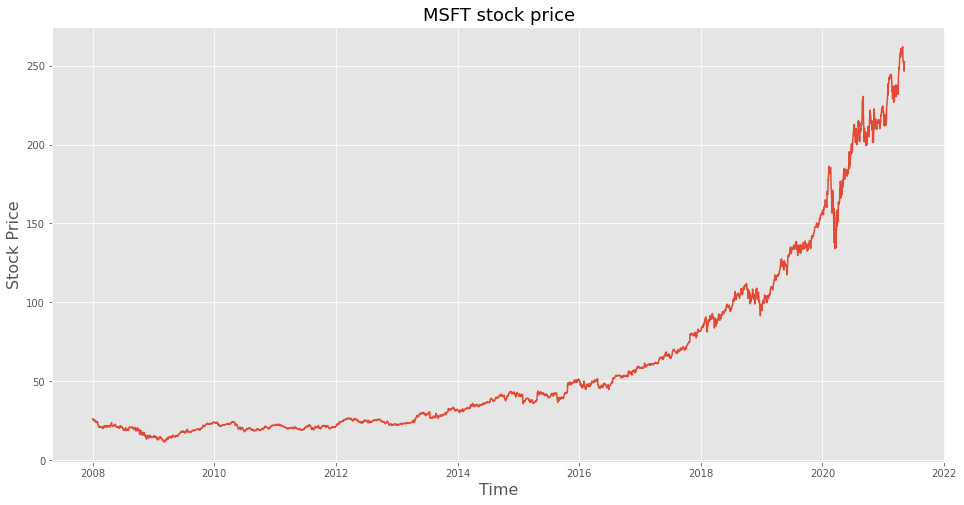

In [ ]:
plt.figure(figsize= (16,8))
plt.plot(stock_orig['Adj Close'])
plt.xlabel('Time', fontsize=16)
plt.ylabel('Stock Price', fontsize=16)
plt.title('{} stock price'.format(stock_symbl), fontsize=18)

In [ ]:
tt = create_train_test_split(stock_data)

In [ ]:
tt[0]

,High,Low,Open,Volume,SMA_Close_20,SMA_Close_50,SMA_Close_80,SMA_Close_100,SMA_Close_200,operatingIncome,grossProfit,totalRevenue,RSI,macd_fast,macd_slow,MACD,macd_signal,ATR,OBV,BB_upper,BB_lower,ADX
2011-06-30,25.709999,25.360001,25.709999,66051000.0,19.648545,19.972131,20.117090,20.360752,20.720981,27161.0,54366.0,69943.0,66.431849,20.087162,19.887416,0.199746,0.013183,4.991022,-2.583184e+09,19.888164,19.408926,16.654653
2011-07-01,26.000000,25.660000,25.740000,52535400.0,19.733278,19.979002,20.120088,20.345406,20.725622,27161.0,54366.0,69943.0,66.608659,20.211946,19.962293,0.249653,0.060477,5.001076,-2.530648e+09,19.945881,19.520675,18.231612
2011-07-05,26.170000,25.840000,25.930000,52906200.0,19.814397,19.989864,20.127974,20.332599,20.730736,27161.0,54366.0,69943.0,66.703139,20.318769,20.032219,0.286550,0.105692,5.028915,-2.477742e+09,20.033567,19.595227,19.916884
2011-07-06,26.150000,25.900000,26.100000,37805300.0,19.905556,20.004108,20.136178,20.325929,20.736227,27161.0,54366.0,69943.0,69.491947,20.446226,20.114813,0.331413,0.150836,5.046506,-2.439937e+09,20.165711,19.645401,21.481779
2011-07-07,26.370001,25.959999,25.969999,48744200.0,20.019204,20.016165,20.148700,20.324777,20.744590,27161.0,54366.0,69943.0,73.056381,20.608443,20.217467,0.390976,0.198864,5.066493,-2.391192e+09,20.347975,19.690432,23.227596
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-11-12,111.449997,108.760002,110.849998,32039200.0,104.424529,106.781796,106.065536,104.488029,97.840794,99550.0,191790.0,290840.0,46.334838,104.885963,105.178425,-0.292461,-0.709267,5.038568,-2.455538e+09,107.969479,100.879578,25.388792
2018-11-13,109.959999,106.099998,109.419998,33621800.0,104.227887,106.689385,106.058076,104.555012,97.915305,99550.0,191790.0,290840.0,46.492491,104.686585,105.060764,-0.374179,-0.642249,5.194387,-2.421916e+09,107.611672,100.844102,25.261180
2018-11-14,108.739998,106.639999,107.550003,35374600.0,103.971842,106.629975,106.035993,104.626797,97.971618,99550.0,191790.0,290840.0,43.509796,104.291879,104.843003,-0.551124,-0.624024,4.892582,-2.457291e+09,107.153409,100.790275,25.142682
2018-11-15,108.260002,104.470001,108.099998,39495100.0,103.935200,106.610669,106.003764,104.714397,98.042754,99550.0,191790.0,290840.0,48.909710,104.303636,104.807840,-0.504204,-0.600060,5.019470,-2.417796e+09,106.881342,100.989057,25.602158


In [ ]:
scaler = MinMaxScaler()

X_train = scaler.fit_transform(tt[0])
y_train = tt[1]

X_val = scaler.transform(tt[2])
y_val = tt[3]

X_test  = scaler.transform(tt[4])
y_test  = tt[5]

print('Scaled X_train Shape :', X_train.shape)
print('Scaled y_train Shape :', y_train.shape)
print('\n')
print('Scaled X_val Shape :', X_val.shape)
print('Scaled y_val Shape :', y_val.shape)
print('\n')
print('Scaled X_test Shape :', X_test.shape)
print('Scaled y_test Shape :', y_test.shape)


Scaled X_train Shape : (1860, 22)
Scaled y_train Shape : (1860, 1)


Scaled X_val Shape : (372, 22)
Scaled y_val Shape : (372, 1)


Scaled X_test Shape : (248, 22)
Scaled y_test Shape : (248, 1)


In [ ]:
X_sclaed = np.append(X_train, np.append(X_val, X_test, axis=0)  ,axis=0)


## $\textbf{SVR}$

In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

svr_reg = SVR()
params = {'kernel' :['linear', 'rbf'], 'gamma':[1e-9,1e-8,1e-7,1e-6], 'C':[400,500,700,900,1200]}
grid_svr = GridSearchCV(svr_reg,params,scoring='neg_mean_squared_error',cv=8, verbose=4)
grid_svr.fit(X_train, np.ravel(y_train))

Fitting 8 folds for each of 40 candidates, totalling 320 fits
[CV] C=400, gamma=1e-09, kernel=linear ...............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .. C=400, gamma=1e-09, kernel=linear, score=-0.044, total=   7.7s
[CV] C=400, gamma=1e-09, kernel=linear ...............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.7s remaining:    0.0s


[CV] .. C=400, gamma=1e-09, kernel=linear, score=-0.036, total=   6.3s
[CV] C=400, gamma=1e-09, kernel=linear ...............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   14.0s remaining:    0.0s


[CV] .. C=400, gamma=1e-09, kernel=linear, score=-0.044, total=   8.2s
[CV] C=400, gamma=1e-09, kernel=linear ...............................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   22.2s remaining:    0.0s


[CV] .. C=400, gamma=1e-09, kernel=linear, score=-0.070, total=   7.7s
[CV] C=400, gamma=1e-09, kernel=linear ...............................
[CV] .. C=400, gamma=1e-09, kernel=linear, score=-0.195, total=   7.3s
[CV] C=400, gamma=1e-09, kernel=linear ...............................
[CV] .. C=400, gamma=1e-09, kernel=linear, score=-0.098, total=   6.2s
[CV] C=400, gamma=1e-09, kernel=linear ...............................
[CV] .. C=400, gamma=1e-09, kernel=linear, score=-0.095, total=   6.9s
[CV] C=400, gamma=1e-09, kernel=linear ...............................
[CV] .. C=400, gamma=1e-09, kernel=linear, score=-0.659, total=   5.3s
[CV] C=400, gamma=1e-09, kernel=rbf ..................................
[CV] ... C=400, gamma=1e-09, kernel=rbf, score=-394.515, total=   0.3s
[CV] C=400, gamma=1e-09, kernel=rbf ..................................
[CV] ... C=400, gamma=1e-09, kernel=rbf, score=-341.806, total=   0.3s
[CV] C=400, gamma=1e-09, kernel=rbf ..................................
[CV] .

[Parallel(n_jobs=1)]: Done 320 out of 320 | elapsed: 33.4min finished


GridSearchCV(cv=8, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [400, 500, 700, 900, 1200],
                         'gamma': [1e-09, 1e-08, 1e-07, 1e-06],
                         'kernel': ['linear', 'rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=4)

In [ ]:
grid_svr.best_params_


{'C': 1200, 'gamma': 1e-09, 'kernel': 'linear'}

In [ ]:
y_predic_svr = grid_svr.predict(X_val)
print('Train MSE :', mean_squared_error(np.ravel(y_train), grid_svr.predict(X_train)))
print('Val MSE :', mean_squared_error(np.ravel(y_val), y_predic_svr))
print('Test MSE :', mean_squared_error(np.ravel(y_test),grid_svr.predict(X_test)))

Train MSE : 0.12730441209423268
Val MSE : 4.208047637130964
Test MSE : 4.725257685643756


In [ ]:
#np.ravel(grid_svr.best_estimator_.coef_)

Text(0.5, 1.0, 'Feature Importance MSFT')

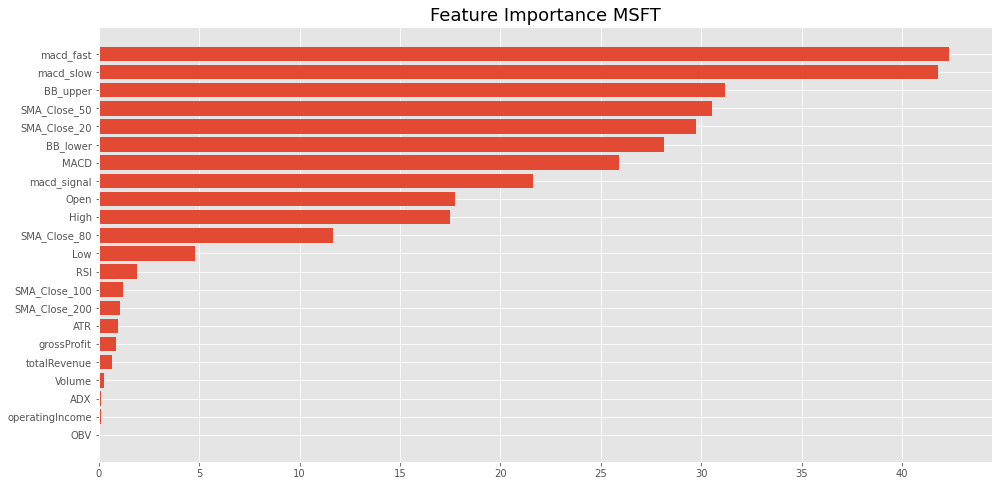

In [ ]:
zip_df = pd.DataFrame( zip(tt[0].columns.tolist(), np.ravel(grid_svr.best_estimator_.coef_)), columns=['Name', 'Coef'])
zip_df['Abs_coef'] = abs(zip_df['Coef'])

plt.figure(figsize=(16,8))
plt.barh(zip_df.sort_values('Abs_coef')['Name'], zip_df.sort_values('Abs_coef')['Abs_coef']         )
plt.title('Feature Importance {}'.format(stock_symbl), fontsize=18)

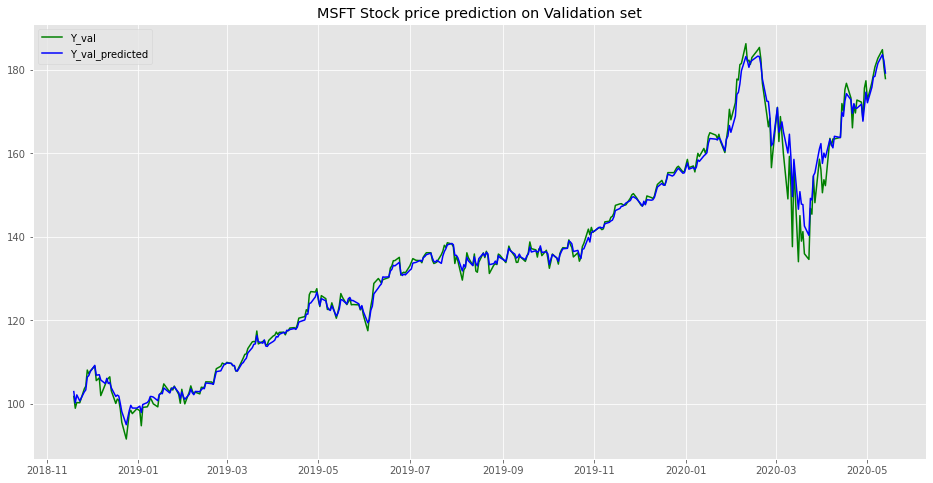

In [ ]:
y_rand_svr = y_val.copy(True)
y_rand_svr['y_val_predicted'] = y_predic_svr
y_rand_svr.rename(columns={'Adj Close' : 'y_val'}, inplace=True)

plt.figure(figsize=(16,8))
plt.plot(y_rand_svr.iloc[:,0], 'g-', label='Y_val')
plt.plot(y_rand_svr.iloc[:,1], 'b-', label='Y_val_predicted')
plt.title('MSFT Stock price prediction on Validation set')
plt.legend()

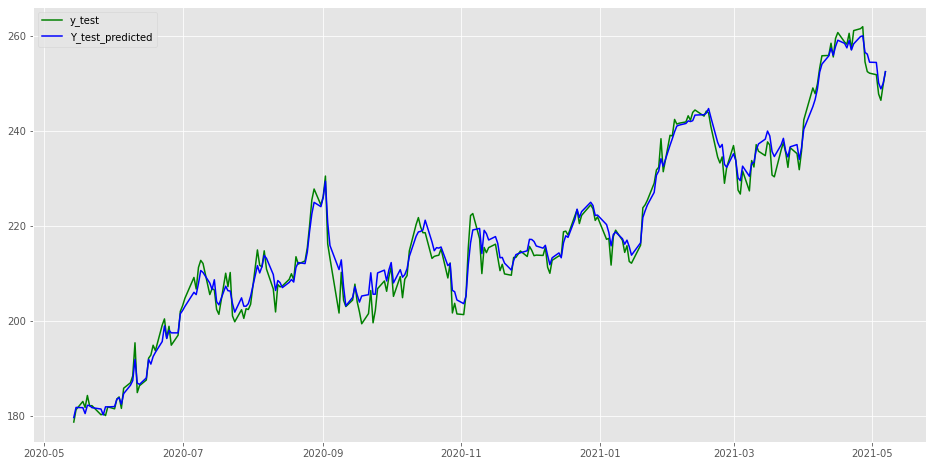

In [ ]:

# plt.figure(figsize=(16,8))
# plt.plot(stock_data['Adj Close'], 'g-', label='Stock_Price')
# plt.plot(pd.DataFrame(grid_svr.predict(X_sclaed), index=stock_data.index), 'b-', label='Y_val_predicted')
# plt.legend()

plt.figure(figsize=(16,8))
plt.plot(y_test, 'g-', label='y_test')
plt.plot(pd.DataFrame(grid_svr.predict(X_test), index=y_test.index), 'b-', label='Y_test_predicted')
plt.title('{} Stock price prediction on Test set'.format(stock_symbl))
plt.legend()

## $\textbf{LSTM}$

In [ ]:
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
X_val = X_val.reshape((X_val.shape[0],X_val.shape[1],1))
X_test  = X_test.reshape((X_test.shape[0],X_test.shape[1],1))


In [ ]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)  ))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam',loss='mean_squared_error')
model.fit(X_train,y_train,epochs=200,batch_size=32)



Epoch 1/200
59/59 [==============================] - 11s 80ms/step - loss: 2481.6711
Epoch 2/200
59/59 [==============================] - 5s 84ms/step - loss: 1887.5184
Epoch 3/200
59/59 [==============================] - 5s 84ms/step - loss: 1675.9579
Epoch 4/200
59/59 [==============================] - 5s 84ms/step - loss: 1381.2661
Epoch 5/200
59/59 [==============================] - 5s 83ms/step - loss: 1273.1486
Epoch 6/200
59/59 [==============================] - 5s 85ms/step - loss: 1154.0755
Epoch 7/200
59/59 [==============================] - 5s 84ms/step - loss: 1079.6507
Epoch 8/200
59/59 [==============================] - 5s 86ms/step - loss: 962.5661
Epoch 9/200
59/59 [==============================] - 5s 87ms/step - loss: 890.7589
Epoch 10/200
59/59 [==============================] - 5s 86ms/step - loss: 810.8351
Epoch 11/200
59/59 [==============================] - 5s 85ms/step - loss: 748.2931
Epoch 12/200
59/59 [==============================] - 5s 86ms/step - loss: 72

In [ ]:
y_predic_lstm = model.predict(X_val)


print('Train MSE :', mean_squared_error(np.ravel(y_train), model.predict(X_train)))
print('Val MSE :', mean_squared_error(np.ravel(y_val), y_predic_lstm))
print('Test MSE :', mean_squared_error(np.ravel(y_test),model.predict(X_test)))

Train MSE : 3.0194383846736006
Val MSE : 1577.0266471660777
Test MSE : 13580.404845234076


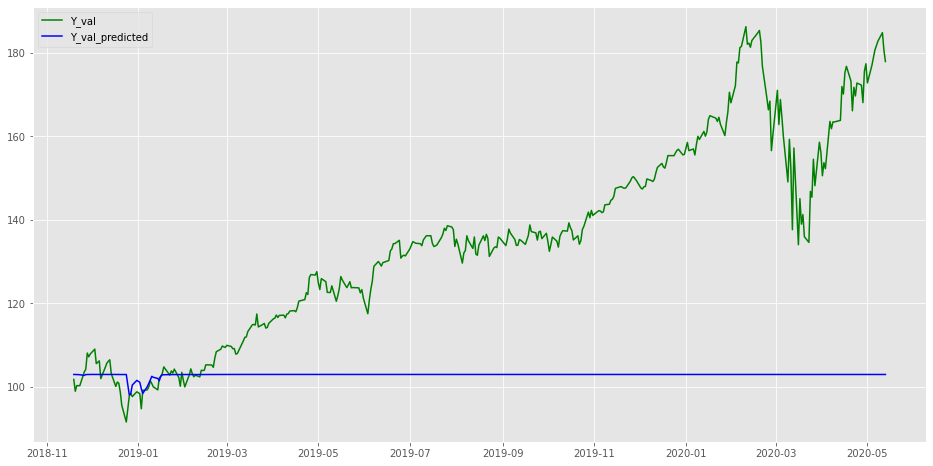

In [ ]:

y_rand_lstm = y_val.copy(True)
y_rand_lstm['y_val_predicted'] = y_predic_lstm
y_rand_lstm.rename(columns={'Adj Close' : 'y_val'}, inplace=True)

plt.figure(figsize=(16,8))
plt.plot(y_rand_lstm.iloc[:,0], 'g-', label='Y_val')
plt.plot(y_rand_lstm.iloc[:,1], 'b-', label='Y_val_predicted')
plt.legend()

## $\textbf{LGBM}$

In [ ]:
from lightgbm import LGBMRegressor

model_lgbm = LGBMRegressor(n_estimators=100000,
                           learning_rate=0.01,
                           max_depth=15,
                           class_weight = 'balanced',


                           )

model_lgbm.fit(X_train, np.ravel(y_train), categorical_feature=[9,10,11])



/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [9, 10, 11]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


KeyboardInterrupt: ignored

In [ ]:
y_predic_lgbm = model_lgbm.predict(X_val)
mean_squared_error(y_val, y_predic_lgbm)

In [ ]:
y_rand = y_val.copy(True)
y_rand['y_val_predicted'] = y_predic_lgbm
y_rand

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(y_rand.iloc[:,0], 'g-', label='Y_val')
plt.plot(y_rand.iloc[:,1], 'b-', label='Y_val_predicted')
plt.legend()

In [ ]:
from lightgbm import plot_importance

fig , ax = plt.subplots(figsize=(16,8))
plot_importance(model_lgbm,ax=ax)

In [ ]:
tt[2].iloc[:,[15,12,3,6,16,21,18,17,0,1,2]]

In [ ]:
tt[2].iloc[:,[5,19,13,4,20,6,14,8,7,11]]

## $\textbf{XGBoost}$

In [ ]:
from xgboost import XGBRegressor

model_xgb = XGBRegressor(n_estimators=100000,
                         learning_rate=0.01,
                         max_depth=5
                         )
model_xgb.fit(tt[0], np.ravel(y_train))

In [ ]:
y_predic_xgb = model_xgb.predict(tt[2])
print('Train MSE :', mean_squared_error(np.ravel(y_train), grid_svr.predict(tt[0])))
print('Val MSE :', mean_squared_error(np.ravel(y_val), y_predic_xgb))

## $\textbf{Catboost}$

In [ ]:
!pip install catboost
from catboost import CatBoostRegressor

In [ ]:
model_cat = CatBoostRegressor(iterations=100000,
                              learning_rate =0.01,
                              )
model_cat.fit(tt[0], np.ravel(y_train))

In [ ]:
y_predic_cat = model_cat.predict(tt[2])
print('Train MSE :', mean_squared_error(np.ravel(y_train), grid_svr.predict(tt[0])))
print('Val MSE :', mean_squared_error(np.ravel(y_val), y_predic_cat))

In [ ]:
y_rand_cat = y_val.copy(True)
y_rand_cat['y_val_predicted'] = y_predic_cat
y_rand_cat

plt.figure(figsize=(16,8))
plt.plot(y_rand_cat.iloc[:,0], 'g-', label='Y_val')
plt.plot(y_rand_cat.iloc[:,1], 'b-', label='Y_val_predicted')
plt.legend()